In [182]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import simpson
from scipy.optimize import curve_fit
from scipy import constants

Additional constants for the data processing

In [183]:
frequency = 80 * 10**6

In [184]:
def normalize(y):
    return (y - y.min()) / (y.max() - y.min())

# 1. Spectrometer measurements

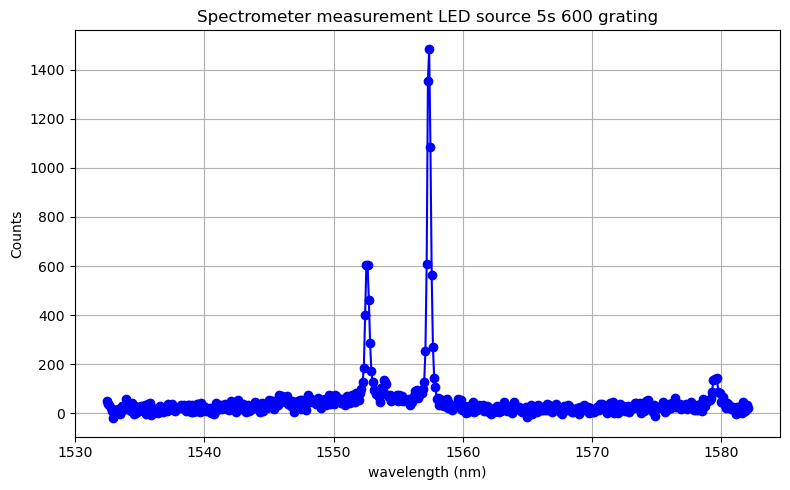

In [185]:
filename = "Data/Spectrometer_measurement_LED_source_5s_600_grating.asc"

data = np.loadtxt(filename)

x = data[:, 0]
y = data[:, 1]

plt.figure(figsize=(8, 5))
plt.plot(x, y, marker='o', linestyle='-', color='blue')
plt.title("Spectrometer measurement LED source 5s 600 grating")
plt.xlabel("wavelength (nm)")
plt.ylabel("Counts")
plt.grid(True)
plt.tight_layout()
plt.show()

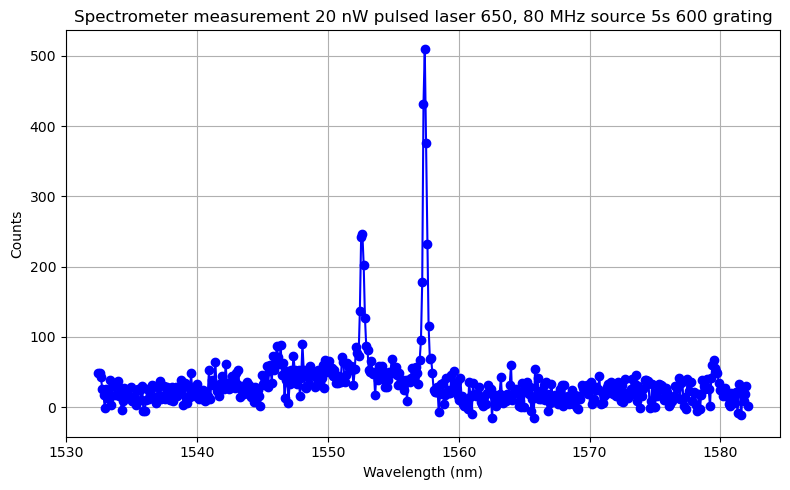

In [186]:
filename = "Data/Spectrometer_measurement_200nW_plused_laser650_80MHz_source_5s_600_grating.asc"

data = np.loadtxt(filename)

x = data[:, 0]
y = data[:, 1]

plt.figure(figsize=(8, 5))
plt.plot(x, y, marker='o', linestyle='-', color='blue')
plt.title("Spectrometer measurement 20 nW pulsed laser 650, 80 MHz source 5s 600 grating")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Counts")
plt.grid(True)
plt.tight_layout()
plt.show()

To count the efficiency of the lazer, we take total count of spectrometer values(over 5 seconds time) and divide by lazer frequency * 5 sec 

$$
\eta = \frac{n_{\text{ spectrometer 5 sec}}}{\nu * 5}
$$

In [187]:
# Effectiveness total sum of spectroscopy values / (80mhz source *5)
total_counts = np.sum(y)

efficiency = total_counts / (5* frequency)
print("Retrieved efficiency:", efficiency * 10 ** 5, "* 10^-5")

Retrieved efficiency: 4.17475 * 10^-5


## 1.1 Useful functions


 Gaussian Function (for homogeneously broadened lines):
 $$
 F(x) = A \cdot  e^{-\frac{(x-x_0)^2}{2 \sigma^2}} + y
 $$
- $A$: Amplitude
- $x_0$: Peak position
- $\sigma$: Standard deviation (related to the linewidth)
- $y$: min value of the data

 Lorentzian Function (for inhomogeneously broadened lines):
$$
 F(x) = \frac{A}{\pi} \cdot \frac{\Gamma}{(x-x_0)^2 + \Gamma^2} + y
 $$
- $A$: Amplitude
- $x_0$: Peak position
- $\Gamma$: Half-width at half-maximum (related to the linewidth)
- $y$: min value of the data

In [188]:
def gaussian(x, A, x0, sigma, y0):
    return A * np.exp(-(x - x0)**2 / (2 * sigma**2)) +y0

def lorentzian(x, A, x0, gamma,y0):
    return (A/np.pi) * (gamma / ((x - x0)**2 + gamma**2)) + y0

def get_data_in_interval(x, y, start, end):
    mask = (x >= start) & (x <= end)
    return x[mask], y[mask]

def fit_curve(function, x, y, start, end, p0):
    x_interval, y_interval = get_data_in_interval(x, y, start, end)
    popt, pcov = curve_fit(function, x_interval, y_interval, p0, maxfev = 5000)
    y_fit = function(x_interval, *popt)
    return popt, pcov, y_fit

def fit_quality_metrics(x, y, model, popt, name="model"):
    """
    Compute residuals, SSR, R2, chi2, reduced chi2, AIC, BIC, param uncertainties.
    
    Inputs:
      x, y         : data arrays (same length)
      model        : callable model(x, *popt)
      popt         : fitted parameters (array-like)
      pcov         : covariance matrix from curve_fit (or None)
      sigma        : measurement uncertainties per point (array-like or scalar) or None
      name         : string label for prints
    
    Returns:
      results dict with keys:
        residuals, ssr, r2, chi2, red_chi2, dof, aic, bic, param_errs
    """
    y_model = model(x, *popt)
    residuals = y - y_model

    chi2_element = ((y-y_model)**2)/y_model
    ssr = np.sum(residuals**2)
    chi2_val = np.sum(chi2_element)

    results = dict(
        name=name,
        ssr=ssr,
        chi2=chi2_val,
        residuals=np.sum(residuals)
    )
    return results

def print_fit_summary(res):
    print(f"=== Fit summary: {res['name']} ===")
    print(f"SSR: {res['ssr']:.6g}")
    print(f"Chi^2: {res['chi2']:.6g}")
    print(f"Residuals: {res['residuals']:.6g}")

## 1.2 Fitting the data to the Gaussian and Lorentzian curves

### 1.2.1 Wave interval we're going to work on

In [ ]:
wavemin, wavemax = 1555, 1560  # nm

### 1.2.2 Initial guesses for Gaussian and lorentzian curves

In [190]:
A0 = y.max()
x0 = x[np.argmax(y)]
print(x0)
sigma0 = 1
gamma0 = (x.max() - x.min()) / 20
y0 = -y.min()

1557.4


### 1.2.3 Calculating Gaussian curve parameters

$$FWHM = 2\sqrt{2 \ln 2} \sigma \approx 2.355 \sigma

In [191]:
popt_gaussian, pcov_gaussian, y_fit_gaussian = fit_curve(
        gaussian,
        x,
        y,
        wavemin,
        wavemax,
        p0=[A0, x0, sigma0, y0]
    )

A_g, x0_g, sigma_g, y0_g = popt_gaussian
fwhm_gaussian = 2.355 * np.abs(sigma_g)

print(f"Fit completed: \nA = {A_g:.3f}\nx₀ = {x0_g:.3f} nm\nσ = {sigma_g:.3f} nm, y0 = {y0_g:.3f}")
print(f"FWHM = {fwhm_gaussian:.3f}")

Fit completed: 
A = 466.210
x₀ = 1557.401 nm
σ = -0.143 nm, y0 = 34.838
FWHM = 0.337


### 1.2.4 Calculating Lorentzian curve parameters

$$
FWHM = 2 \Gamma
$$

In [192]:
popt_lorentzian, pcov_lorentzian, y_fit_lorentzian = fit_curve(
        lorentzian,
        x,
        y,
        wavemin,
        wavemax,
        p0=[A0, x0, gamma0, y0]
    )

A_l, x0_l, gamma_l, y0_l = popt_lorentzian
fwhm_lorentzian = 2 * gamma_l

print(f"Fit completed: \nA = {A_l:.3f}\nx₀ = {x0_l:.3f} nm\nΓ = {gamma_l:.3f} nm, y0 = {y0_l:.3f}")
print(f"FWHM = {fwhm_lorentzian:.3f}")

Fit completed: 
A = 230.397
x₀ = 1557.396 nm
Γ = 0.143 nm, y0 = 23.755
FWHM = 0.286


### 1.2.5 Data for LaTeX plot

In [193]:
print(f"Gaussian curve parameters: \nA = {A_g}\nx₀ = {x0_g} nm\nσ = {sigma_g} nm, y0 = {y0_g}")
print(f"Lorentzian curve parameters: \nA = {A_l}\nx₀ = {x0_l} nm\nΓ = {gamma_l} nm, y0 = {y0_l}")

Gaussian curve parameters: 
A = 466.21028291718164
x₀ = 1557.4011751036874 nm
σ = -0.14295119115288032 nm, y0 = 34.837796116285
Lorentzian curve parameters: 
A = 230.39709708539093
x₀ = 1557.3960880889977 nm
Γ = 0.14301780908946 nm, y0 = 23.755240696935655


## 1.3 Plottting the curves againt the data

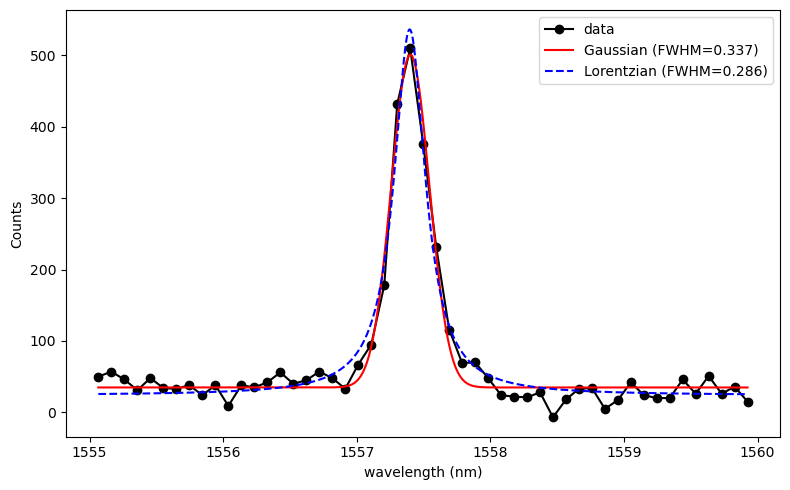

In [194]:
x_interval, y_interval= get_data_in_interval(x, y, wavemin, wavemax)
x_fit = np.linspace(x_interval[0], x_interval[-1], 1000)

plt.figure(figsize=(8,5))
plt.plot(x_interval, y_interval, marker='o', linestyle='-', color='black', label = "data")
plt.plot(x_fit, gaussian(x_fit, *popt_gaussian), 'r-', label=f'Gaussian (FWHM={fwhm_gaussian:.3f})')
plt.plot(x_fit, lorentzian(x_fit, *popt_lorentzian), 'b--', label=f'Lorentzian (FWHM={fwhm_lorentzian:.3f})')
plt.xlabel("wavelength (nm)")
plt.ylabel("Counts")
plt.legend()
plt.tight_layout()
plt.show()

- if the gaussian fits better - that means you got more noise.

## 1.4 Calculating $\chi^2$ and residuals

In [195]:
res_g = fit_quality_metrics(
    x=x_interval,
    y=y_interval,
    model=gaussian,
    popt=popt_gaussian,
    name="Gaussian"
)

res_l = fit_quality_metrics(
    x=x_interval,
    y=y_interval,
    model=lorentzian,
    popt=popt_lorentzian,
    name="Lorentzian"
)

print_fit_summary(res_g)
print_fit_summary(res_l)

=== Fit summary: Gaussian ===
SSR: 14763.5
Chi^2: 316.71
Residuals: 1.1477e-07
=== Fit summary: Lorentzian ===
SSR: 16820
Chi^2: 354.183
Residuals: 9.9644e-06


# 2. Analyze the obtained decay measurement

In [196]:
file_path = "Data/Decay_measurements_200nW_650_pulsed_80MHz_source_5s_600_grating.txt"

df = pd.read_csv(file_path, sep="\t")

time_col = "Time (ps)"
count_col = "Counts per bin"

x = df[time_col].values.astype(float)
y = df[count_col].values.astype(float)

# change x to from ps to ns
x = x / 1000
# normalize y axis, with normalization or without it returns the same \tau value
y = normalize(y)


$$
F(x) = F_0 + A_1 e^{-\frac{t-t_0}{\tau_1}}
$$
- $F(x)$ = observed signal or intensity at time t.
- $F_0$ = offset or baseline at time t=0. It represents the initial value of the signal when the decay
process begins.
- $A_1$ = amplitude or the difference between the baseline F0 and the peak signal.
- $t_0$ = is the time offset or the time at which the decay process begins. It's the time at which the
decay or emission process starts influencing the signal.
- $\tau_1$ = is the decay constant or the characteristic time constant of the exponential decay
process. It determines how quickly the signal decays from its initial value F0 to 1/e of that initial
value.

In [197]:
def exponential_decay(t, F0, A1, t0, tau1):
    return F0 + A1 * np.exp(-(t - t0) / tau1)

In [198]:
F0 = y[0]
A1 = np.max(y)- F0
p0 = [
    F0,                          # F0_guess (baseline)
    A1,                          # A1_guess (amplitude)
    1,                           # t0_guess (time offset)
    0.5                          # tau1_guess (decay constant)
]

## 2.1 Retrieve parameters for exponential decay

In [199]:
peak_index = np.argmax(y)
end = np.max(x)
x_fit = x[peak_index:]
y_fit = y[peak_index:]

popt_exp, pcov_exp, y_fit_exp = fit_curve(
    exponential_decay,
    x_fit,
    y_fit,
    start = x_fit[0],
    end = x_fit[-1],
    p0=p0)

F0_fit, A1_fit, t0_fit, tau1_fit = popt_exp

print("--- Best Fit Parameters ---")
print(f"F0 (Baseline):   {F0_fit:.3f}")
print(f"A1 (Amplitude):  {A1_fit:.3f}")
print(f"t0 (Time Offset): {t0_fit:.3f} (Time Units)")
print(f"tau1 (Lifetime): {tau1_fit:.3f} (Time Units)")
print("-" * 30)

--- Best Fit Parameters ---
F0 (Baseline):   0.006
A1 (Amplitude):  2.506
t0 (Time Offset): 0.980 (Time Units)
tau1 (Lifetime): 0.895 (Time Units)
------------------------------


### 2.1.1 Parameters for LaTeX

In [200]:
print("--- Best Fit Parameters ---")
print(f"F0:   {F0_fit}")
print(f"A1:  {A1_fit}")
print(f"t0: {t0_fit}")
print(f"tau1: {tau1_fit}")

--- Best Fit Parameters ---
F0:   0.006013764094203587
A1:  2.5059593643935996
t0: 0.9796180029930935
tau1: 0.8952988360958762


## 2.2 Plotting

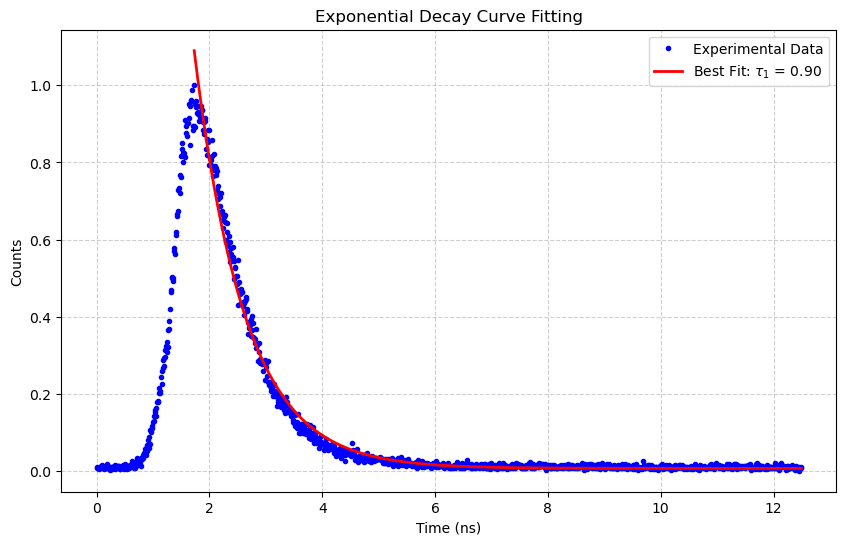

In [201]:
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'bo', markersize=3, label='Experimental Data')
plt.plot(x_fit, y_fit_exp, 'r-', linewidth=2, label=f'Best Fit: $\\tau_1$ = {tau1_fit:.2f}')

plt.title('Exponential Decay Curve Fitting')
plt.xlabel('Time (ns)')
plt.ylabel('Counts')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## 2.3 $\chi^2$ and residuals

In [202]:
res_exp = fit_quality_metrics(
    x=x_fit,
    y=y_fit,
    model=exponential_decay,
    popt=popt_exp,
    name="Exponential decay"
)

print_fit_summary(res_exp)

=== Fit summary: Exponential decay ===
SSR: 0.380331
Chi^2: 4.07891
Residuals: 0.00011735


### Save data for LaTeX plot

In [203]:
output_filename = "Data/Decay_normalized.csv"
df = pd.DataFrame({'Time_ns': x/1000, 'Normalized_counts': y})
df.to_csv(output_filename, index=False)

## 2.4 Retrieve linewidth from decay 

$$
\Delta \nu = \frac{1}{2 \pi \tau_1}
$$

$$
\Delta \lambda = \frac{\lambda^2}{c} \Delta \nu
$$

In [204]:
# linewidth Δν=1/(2πτ)
tau1_seconds = tau1_fit / 10**9
delta_niu = 1/(2*np.pi*tau1_seconds)

print(delta_niu)
print(x0) # peak wavelength of the emission line
lambda_0 = x0 / 10**9
delta_lambda = lambda_0**2 * delta_niu /constants.c
print("Retrieved delta lambda from decay function:", delta_lambda * 10**12, "(pm)")
print("Linewidth:", 2*delta_lambda * 10**12, "(pm)")

177767396.3990853
1557.4
Retrieved delta lambda from decay function: 1.4382412797883806 (pm)
Linewidth: 2.876482559576761 (pm)


Reasons why theoretical linewidth is 2 orders of magnitude smaller:
- Charged noise
- Phonons
- Problems with your resolution - pixel, width of the smallest difference between $lambda$ values, sensitivity of the sensor ( it as not as big of a problem as other two, but it might also have some effect)

# 3. Purity (Hanbury Brown-Twiss Measurements) 

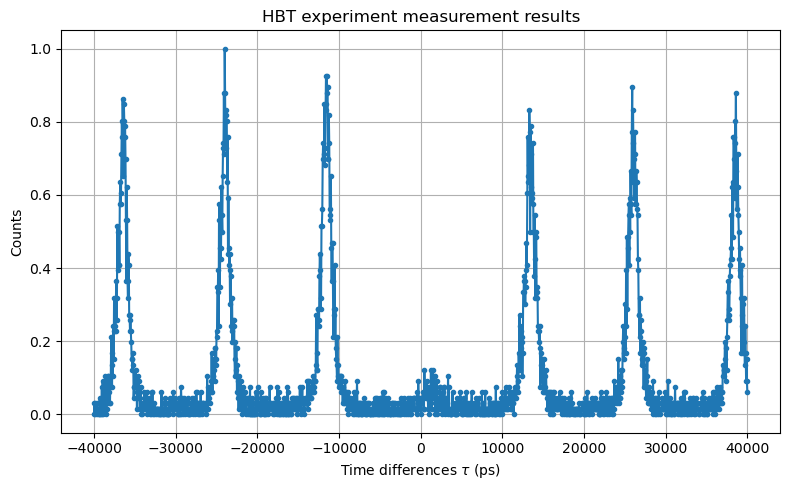

In [205]:
df = pd.read_csv("Data/HBT_measurements_200nW_650_pulsed_80MHz_source_600_grating.txt", sep="\t")
time_col = "Time differences (ps)"
count_col = "Counts per bin"

x = df[time_col].values.astype(float)
y = df[count_col].values.astype(float)
y=normalize(y)
range_time = 40000

df_filtered = df[(x >= -range_time) & (x <= range_time)]

plt.figure(figsize=(8, 5))
plt.plot(df_filtered[time_col], normalize(df_filtered[count_col]), marker='o', linestyle='-', linewidth=1.5, markersize=3)
plt.title("HBT experiment measurement results")
plt.xlabel("Time differences $\\tau$ (ps)")
plt.ylabel("Counts")
plt.grid(True)
plt.tight_layout()
plt.show()

Saving filtered data for LaTeX graphs

In [206]:
output_filename = "Data/HBT_filtered_data.csv"
df = pd.DataFrame({'Time_ns': x/1000, 'Normalized_counts': y})

df_filtered = df[(x >= -range_time) & (x <= range_time)]
df_filtered.to_csv(output_filename, index=False)

In [207]:
def area(df, point:int, integration_window, time_col, count_col) -> float:
    min_point = point - integration_window
    max_point = point + integration_window

    window_df = df[
        (df[time_col] >= min_point) & 
        (df[time_col] <= max_point)
    ].copy()

    x_values = window_df[time_col].values
    y_values = window_df[count_col].values
    
    integral_area = simpson(y=y_values, x=x_values)
    
    return integral_area

def average_of_side_peaks(df, frequency, integration_window, time_col, count_col, exclude_first = False, time="ps") -> float:
    x = df[time_col].values.astype(float)
    x_max = np.max(x)

    if time == "ps":
        period = (1 / frequency) * 10**12
    elif time == "ns":
        period = (1 / frequency) * 10**9

    counts = int(np.floor(x_max / period))
    areas = []
    
    if exclude_first:
        start = 2
    else:
        start = 1

    for i in range(start, counts+1):
        point = period*i
        areas.append(area(df, point, integration_window, time_col, count_col))
        areas.append(area(df, -point, integration_window, time_col, count_col))
    
    average_area = np.mean(areas)
    return average_area

## 3.1 Calculating $g^2(0)$

To calculate $g^2(x)$ in HBT experiment, we need to calculate the area under the center curve ($\pm$ 12500(ps) / 2 ) intergration window and divide by the average value of the side peak sums(same integration window)

Purity can be calculated as:
$$
p = 1 - g^2(0)
$$

- $p=0$: not pure light at all
- $p=1$: pure light

In [208]:
# then a good integration window is maybe ±1 ns around each center
integration_window = 12.5 / 2
c0 = area(df, 0, integration_window, "Time_ns", "Normalized_counts")
c1 = average_of_side_peaks(df, frequency, integration_window, "Time_ns", "Normalized_counts", time="ns")

g2_0 = c0 / c1
purity = 1 - g2_0

print(f"\nCoincidence Count at Zero Delay (C0): {c0:.2f}")
print(f"Average Accidental Coincidence Count (C_acc): {c1:.2f}")
print("\n----------------------------------------------------")
print(f"Calculated Second-Order Correlation Function: g^(2)(0) = {g2_0:.3f}")
print(f"Calculated Single-Photon Source Purity: Purity = {purity:.3f}")
print("----------------------------------------------------")


Coincidence Count at Zero Delay (C0): 0.29
Average Accidental Coincidence Count (C_acc): 1.23

----------------------------------------------------
Calculated Second-Order Correlation Function: g^(2)(0) = 0.238
Calculated Single-Photon Source Purity: Purity = 0.762
----------------------------------------------------


# 4. HOM visibility extraction Procedure

Previously defined constants for the experiment

In [209]:
V_class = 1           # Classical visibility of the Mach-Zehnder
R = 0.50              # Reflectance of the beam splitter
T = 0.50              # Transmittance of the beam splitter

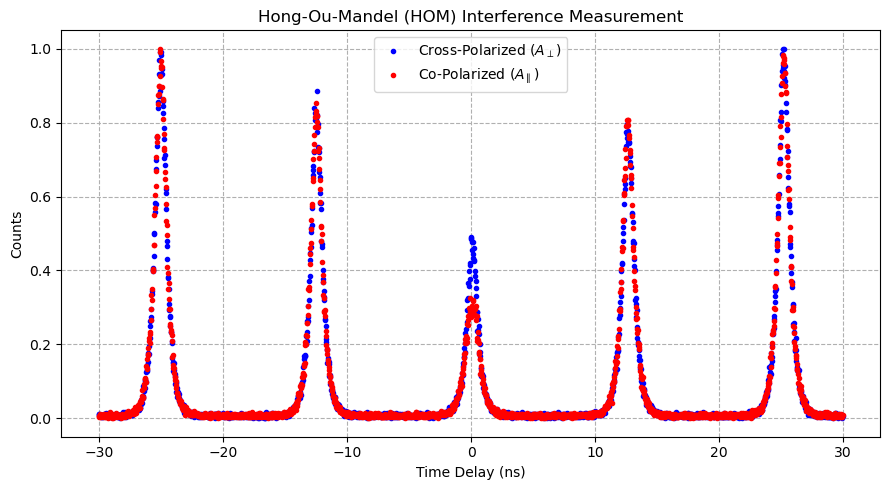

In [210]:
file_path = "Data/HOM_co- and cros-polarization.csv"
df = pd.read_csv(file_path, skiprows=1)

# Rename columns for clarity (as provided in the prompt)
time_co = "Time_co"
coincidence_co = "Coincidence_co"
time_cross = "Time_cross"
coincidence_cross = "Coincidence_cross"

df.columns = [
    time_co, coincidence_co, "empty1", time_cross, coincidence_cross
]

# Drop the empty column
df = df.drop(columns=["empty1"])
df[coincidence_cross] = normalize(df[coincidence_cross])
df[coincidence_co] = normalize(df[coincidence_co])
plt.figure(figsize=(9, 5))
plt.plot(df[time_cross], df[coincidence_cross], 'o', markersize=3, label='Cross-Polarized ($A_{\perp}$)', color='blue')
plt.plot(df[time_co], df[coincidence_co], 'o', markersize=3, label='Co-Polarized ($A_{\parallel}$)', color='red')
plt.title("Hong-Ou-Mandel (HOM) Interference Measurement")
plt.xlabel("Time Delay (ns)")
plt.ylabel("Counts")
plt.legend()
plt.grid(True, linestyle='--')
plt.tight_layout()
plt.show()

In [211]:
output_filename = "Data/HOM_CO_normalized.csv"
df_sub = pd.DataFrame({'Time_ns': df[time_co], 'Normalized_counts': df[coincidence_co]})
df_sub.to_csv(output_filename, index=False)
output_filename = "Data/HOM_Cross_normalized.csv"
df_sub = pd.DataFrame({'Time_ns': df[time_cross], 'Normalized_counts': df[coincidence_cross]})
df_sub.to_csv(output_filename, index=False)

Formula to calculate $\nu_{HOM}$:
$$
\nu_{HOM} = 1 - \frac{A_{\parallel}}{A_{\perp}}
$$

Again, $A_{\parallel}$ and $A_{\perp}$ can be calculated by taking the area under the peak (integration window here is $\pm$ 12.5 / 2) and dividing by the average area under the peaks for respective graphs.

In [212]:
integration_window = 6.25

co_polarization_center = area(df, 0, integration_window, time_co, coincidence_co)
co_polarization_side = average_of_side_peaks(df, frequency, integration_window, time_co, coincidence_co, exclude_first=True, time="ns")

normalized_area_co = co_polarization_center/co_polarization_side

cross_polarization_center = area(df, 0, integration_window, time_cross, coincidence_cross)
cross_polarization_side = average_of_side_peaks(df, frequency, integration_window, time_cross, coincidence_cross, exclude_first=True, time="ns")

normalized_area_cross = cross_polarization_center / cross_polarization_side

v_raw = 1- normalized_area_co / normalized_area_cross
print("-------------------------------------------------")
print(f"Normalized Co-Pol Area ($A_{{\\parallel}}$): {normalized_area_co:.5f}")
print(f"Normalized Cross-Pol Area ($A_{{\\perp}}$): {normalized_area_cross:.5f}")
print(f"Calculated Raw HOM Visibility ($V_{{Raw}}$): {v_raw:.5f}")


-------------------------------------------------
Normalized Co-Pol Area ($A_{\parallel}$): 0.42509
Normalized Cross-Pol Area ($A_{\perp}$): 0.51382
Calculated Raw HOM Visibility ($V_{Raw}$): 0.17268


To calculate $\nu_{True}$ we use this formula:
$$
\nu_{True} = \frac{1}{V_{Class}^2} (1+2g^2(0))(\frac{R^2+T^2}{2RT})\nu_{Raw}
$$

$\nu_{Raw} = \nu_{HOM}$

This HOM visibility could be used as a indistinguishibility constant:
- $\nu_{True} = 0$: Distinguishable
- $\nu_{True} = 1$: Indistinguishable

In [213]:
first_component = 1 / V_class**2
second_component = 1+2*g2_0
third_component = (R**2+T**2)/(2*R*T) * v_raw

v_true = first_component * second_component * third_component

print("-------------------------------------------------")
print(f"Calculated True Single-Photon HOM Visibility ($V_{{True}}$): {v_true:.5f}")
print("-------------------------------------------------")

-------------------------------------------------
Calculated True Single-Photon HOM Visibility ($V_{True}$): 0.25501
-------------------------------------------------
